In [1]:
# !pip3 install gensim

In [1]:
from Corpora import MovieReviewCorpus
from Lexicon import SentimentLexicon
from Statistics import SignTest
from Classifiers import NaiveBayesText, SVMText
from Extensions import SVMDoc2Vec, DocFeaturizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

ax_size = 16
title_size=18

In [6]:
# retrieve corpus
corpus=MovieReviewCorpus(stemming=False,pos=False)

# use sign test for all significance testing
signTest=SignTest()

print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
# todo: vary this!!! 
thresholds = [0.5, 1, 2, 4, 8, 12]
multipliers = [1.5, 2, 5, 10, 1000]

threshold=8

# question 0.1
lexicon.classify(corpus.reviews,threshold,magnitude=False)
token_preds=lexicon.predictions
token_pred_y = lexicon.pred_y
print(f"token-only results: {lexicon.getAccuracy():.2f}")
mcc = matthews_corrcoef(lexicon.true_y, token_pred_y)
print(f"MCC: {mcc:.2f}")

for multiplier in multipliers: 
    lexicon=SentimentLexicon(multiplier=multiplier)
    lexicon.classify(corpus.reviews,threshold,magnitude=True)
    magnitude_preds=lexicon.predictions
    magnitude_pred_y = lexicon.pred_y
    print(f"multiplier: {multiplier}, magnitude results: {lexicon.getAccuracy():.2f}")
    mcc = matthews_corrcoef(lexicon.true_y, magnitude_pred_y)
    print(f"MCC: {mcc:.2f}")

num train: 1800, num test: 200
tot num reviews: 2000
--- classifying reviews using sentiment lexicon  ---
token-only results: 0.68
MCC: 0.36
multiplier: 1.5, magnitude results: 0.68
MCC: 0.37
multiplier: 2, magnitude results: 0.69
MCC: 0.37
multiplier: 5, magnitude results: 0.69
MCC: 0.38
multiplier: 10, magnitude results: 0.68
MCC: 0.37
multiplier: 1000, magnitude results: 0.68
MCC: 0.36


In [7]:
# question 1.0
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
# store predictions from classifier
non_smoothed_preds=NB.predictions
print(f"Accuracy without smoothing: {NB.getAccuracy():.2f}")

--- classifying reviews using Naive Bayes on held-out test set ---
Accuracy without smoothing: 0.43


In [8]:
# question 2.0
# use smoothing
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
smoothed_preds=NB.predictions
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
print(f"Accuracy using smoothing: {NB.getAccuracy():.2f}")

# question 2.1
# see if smoothing significantly improves results
p_value=signTest.getSignificance(non_smoothed_preds,smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing are {significance} with respect to no smoothing")

Accuracy using smoothing: 0.79
results using smoothing are significant with respect to no smoothing


In [9]:
# question 3.0
print("--- classifying reviews using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus)
# using cross-eval for smoothed predictions from now on
smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy(cross_val_preds=True):.3f}")
print(f"Std. Dev: {NB.getStdDeviation()}")

--- classifying reviews using 10-fold cross-evaluation ---


/Users/kcollins/MLMI13/Analysis.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])


Accuracy: 0.809
Std. Dev: 0.021731313812100698


In [50]:
smoothers = list(range(0,11))
accs = []
stdevs = []
for smoother in smoothers: 
    NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False,
                     laplace_smoother=smoother)
    NB.crossValidate(corpus)
    # using cross-eval for smoothed predictions from now on
    smoothed_preds=NB.predictions
    accs.append(NB.getAccuracy())
    stdevs.append(NB.getStdDeviation())


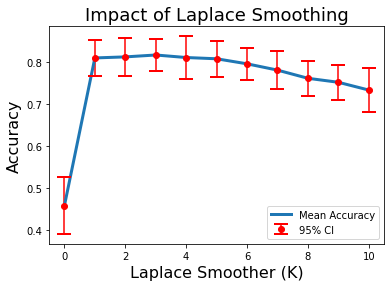

In [51]:
import numpy as np
fig, ax = plt.subplots()
ax.plot(smoothers, accs,linewidth=3.0, label="Mean Accuracy")
ax.errorbar(smoothers, accs, yerr=2*np.array(stdevs),fmt='o',capsize=7,capthick=2, c="r", label="95% CI")
ax.legend()
ax.set_xlabel("Laplace Smoother (K)",fontsize=ax_size)
ax.set_ylabel("Accuracy",fontsize=ax_size)
ax.set_title(f"Impact of Laplace Smoothing",fontsize=title_size) 
ax.legend()
plt.savefig(f"smoother.png", dpi=400)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbdf622f190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbdf622f850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbdf6212df0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbdf622ff10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbdf623a2b0>],
 'means': []}

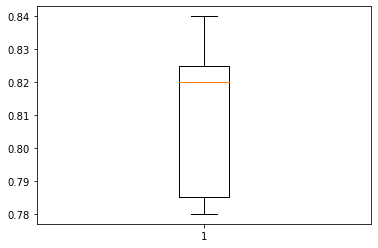

In [7]:
import matplotlib.pyplot as plt
plt.boxplot(NB.score_per_fold)
plt.boxplot()

In [57]:
smoother = 5 # use from now on! 
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False,
                     laplace_smoother=smoother)

NB.crossValidate(corpus)
# using cross-eval for smoothed predictions from now on
smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy(cross_val_preds=True):.3f}")
print(f"Std. Dev: {NB.getStdDeviation()}")
NB.train(corpus.train)
NB.test(corpus.test)
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
print(f"Accuracy using smoothing: {NB.getAccuracy():.2f}")
NB.getMCC()
NB.train(corpus.train)
NB.test(corpus.train)
print(f"Training acc using smoothing: {NB.getAccuracy():.2f}")


# question 4.0
print("--- stemming corpus ---")
# retrieve corpus with tokenized text and stemming (using porter)
stemmed_corpus=MovieReviewCorpus(stemming=True,pos=False)
print("--- cross-validating NB using stemming ---")
NB.crossValidate(stemmed_corpus)
stemmed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy(cross_val_preds=True):.3f}")
print(f"Std. Dev: {NB.getStdDeviation():.3f}")

# TODO Q4.1
# see if stemming significantly improves results on smoothed NB (both did cv)
p_value=signTest.getSignificance(stemmed_preds,smoothed_preds) # note compared against version w/ smoothing! 
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using stemming are {significance} with respect to no stemming")

# TODO Q4.2
print("--- determining the number of features before/after stemming ---")
# (**) changing the number of features == changing the number of words in the vocab 
NB.train(stemmed_corpus.train)
NB.test(stemmed_corpus.test)
print(f"Accuracy using stemming: {NB.getAccuracy():.2f}")
num_stemmed_features = len(NB.vocabulary)
NB.getMCC()
NB.train(corpus.train)
NB.test(corpus.train)
print(f"Training acc using smoothing: {NB.getAccuracy():.2f}")
print(f"num features, non-stemmed: {num_non_stemmed_features} vs. num features, stemmed: {num_stemmed_features}")

/Users/kcollins/MLMI13/Analysis.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])


Accuracy: 0.807
Std. Dev: 0.021124630174277577
Accuracy using smoothing: 0.79
MCC: 0.62
Training acc using smoothing: 0.96
--- stemming corpus ---
num train: 1800, num test: 200
tot num reviews: 2000
--- cross-validating NB using stemming ---


/Users/kcollins/MLMI13/Analysis.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])


Accuracy: 0.819
Std. Dev: 0.020
results using stemming are not significant with respect to no stemming
--- determining the number of features before/after stemming ---
Accuracy using stemming: 0.81
MCC: 0.71
Training acc using smoothing: 0.96
num features, non-stemmed: 52777 vs. num features, stemmed: 32611


In [55]:
len(smoothed_preds)

200

In [59]:
# question Q5.0
# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and bigrams ---")
smoother = 5
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False,
                 laplace_smoother=5)
NB.crossValidate(corpus)
smoothed_and_bigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy(cross_val_preds=True):.2f}") 
print(f"Std. Dev: {NB.getStdDeviation():.2f}")
NB.train(corpus.train)
NB.test(corpus.test)
num_bow_features = len(NB.vocabulary)
print(f"Test accuracy: {NB.getAccuracy():.2f}")
NB.getMCC()
NB.train(corpus.train)
NB.test(corpus.train)
print(f"Training acc: {NB.getAccuracy():.2f}")

# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_bigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams are {signifance} with respect to smoothing only")

num_bow_features = len(NB.vocabulary)
print(f"num features for [model] (Q3): {num_non_stemmed_features} vs. num features BoW: {num_bow_features}")

--- cross-validating naive bayes using smoothing and bigrams ---


/Users/kcollins/MLMI13/Analysis.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])


Accuracy: 0.73
Std. Dev: 0.02
Test accuracy: 0.74
MCC: 0.53
Training acc: 0.99
results using smoothing and bigrams are significant with respect to smoothing only
num features for [model] (Q3): 52777 vs. num features BoW: 502231


In [60]:
# question Q5.0
# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and trigrams ---")
smoother = 5
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=True,discard_closed_class=False,
                 laplace_smoother=5)
NB.crossValidate(corpus)
smoothed_and_trigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy(cross_val_preds=True):.2f}") 
print(f"Std. Dev: {NB.getStdDeviation():.2f}")
NB.train(corpus.train)
NB.test(corpus.test)
num_tri_features = len(NB.vocabulary)
print(f"Test accuracy: {NB.getAccuracy():.2f}")
NB.getMCC()
NB.train(corpus.train)
NB.test(corpus.train)
print(f"Training acc: {NB.getAccuracy():.2f}")

# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_trigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and trigrams are {signifance} with respect to smoothing only")
p_value_both=signTest.getSignificance(smoothed_preds,smoothed_and_trigram_preds)
signifance = "significant" if p_value_both < 0.05 else "not significant"
print(f"results using smoothing and trigrams are {signifance} with respect to smoothing and bigrams")

num_tri_features = len(NB.vocabulary)
print(f"num features for [model] (Q3): {num_non_stemmed_features} vs. num features BoW: {num_tri_features}")

--- cross-validating naive bayes using smoothing and bigrams ---


/Users/kcollins/MLMI13/Analysis.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])


Accuracy: 0.66
Std. Dev: 0.03
Test accuracy: 0.69
MCC: 0.42
Training acc: 1.00
results using smoothing and trigrams are significant with respect to smoothing only
results using smoothing and trigrams are significant with respect to smoothing and bigrams
num features for [model] (Q3): 52777 vs. num features BoW: 1020842


In [61]:
p_value, p_value_both, signTest.getSignificance(smoothed_preds,smoothed_and_bigram_preds)

(Decimal('1.550521554129772768771946807E-11'),
 Decimal('1.550521554129772768771946807E-11'),
 Decimal('0.0007303397540013277104661939067'))

In [10]:
# TODO Q6 and 6.1
print("--- classifying reviews using SVM 10-fold cross-eval ---")
SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False)
SVM.crossValidate(corpus)
svm_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy(cross_val_preds=True):.2f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.2f}")

--- classifying reviews using SVM 10-fold cross-eval ---


/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

Accuracy: 0.82
Std. Dev: 0.02


In [11]:
# # TODO Q6 and 6.1
# corpus = MovieReviewCorpus(stemming=False,pos=False,use_imdb=True)
# print("--- classifying reviews using SVM 10-fold cross-eval ---")
# SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False)
# SVM.train(corpus.train)
# SVM.test(corpus.test)
# svm_preds=SVM.predictions
# print(f"Accuracy: {SVM.getAccuracy():.2f}") 
# print(f"Std. Dev: {SVM.getStdDeviation():.2f}")

In [12]:
p_value=signTest.getSignificance(svm_preds,smoothed_and_bigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using svm {signifance} with respect to naive bayes")

results using svm not significant with respect to naive bayes


In [13]:
# TODO Q7.0
print("--- adding in POS information to corpus ---")
pos_corpus=MovieReviewCorpus(stemming=False,pos=True)
print("--- training svm on word+pos features ----")
SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False)
SVM.crossValidate(pos_corpus)
svm_pos_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy(cross_val_preds=True):.2f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.2f}")
p_value=signTest.getSignificance(svm_pos_preds,svm_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using pos tags {signifance} with respect to not using pos tags")

--- adding in POS information to corpus ---
num train: 1800, num test: 200
tot num reviews: 2000
--- training svm on word+pos features ----


/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

Accuracy: 0.81
Std. Dev: 0.02
results using pos tags not significant with respect to not using pos tags


In [14]:
# TODO: QUESTION 7.1
print("--- training svm discarding closed-class words ---") # QUESTION: do we not use POS here??
SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=True)
SVM.crossValidate(corpus)
svm_preds_closed=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy(cross_val_preds=True):.2f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.2f}")
p_value=signTest.getSignificance(svm_preds_closed,svm_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results discarding closed class {signifance} with respect to keeping the closed class")

--- training svm discarding closed-class words ---


/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_files = np.array([np.array(corpus.folds[fold_j]) for fold_j in range(num_folds) if fold_j != fold_i])
/Users/kcollins/MLMI13/Analysis.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

Accuracy: 0.82
Std. Dev: 0.01
results discarding closed class not significant with respect to keeping the closed class
